In [26]:
%%time

import os, psutil
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree

from time import time

import catboost as cat

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import fowlkes_mallows_score, homogeneity_completeness_v_measure, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score, rand_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

import shap

from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

CPU times: total: 2.39 s
Wall time: 3.99 s


In [11]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv, scoring = {"AUC_OVR_Weighted": "roc_auc_ovr_weighted","AUC_OVO_Weighted": "roc_auc_ovo_weighted", "Accuracy": "accuracy"}):
    scores = cross_validate(
        model, X, y, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifier(name, clf, X_train, y_train, X_test, y_test, cv=5, debug=False, learning_curve=False, confusion=False, supress_outputs=True,cat_features=cat_features):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train, cat_features=cat_features)
  ### END CODE ###
  if supress_outputs == False:
      print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  if supress_outputs == False:
      print("predict time", round(time()-t0, 3), "s")

  if supress_outputs == False:
    print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)

  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###
    
  if supress_outputs == False:
      print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
      print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results

In [3]:
df1 = pd.read_csv('dataset/ObesityDataSet.csv')

df2 = pd.read_csv('dataset/train.csv')
df2 = df2.drop(columns='id')

df = pd.concat([df1, df2], ignore_index=True)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.000000,3.000000,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.000000,3.000000,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.000000,3.000000,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.000000,3.000000,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.000000,1.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
22865,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
22866,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
22867,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


In [4]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
# df['BMI'].hist()
# df['BMI'].describe()

In [5]:
WHObmi_boys = pd.read_csv("dataset/bmi_boys_perc_WHO2007.csv")
WHObmi_girls = pd.read_csv("dataset/bmi_girls_perc_WHO2007.csv")

CDCbmi_boys = pd.read_csv("dataset/bmiagerev_boys.csv")
CDCbmi_girls = pd.read_csv("dataset/bmiagerv_girls.csv")

In [6]:
WHObmi_boys.insert(0, "Age", WHObmi_boys['Month']/12)
WHObmi_boys = WHObmi_boys[WHObmi_boys['Age'] >= 14]

WHObmi_girls.insert(0, "Age", WHObmi_girls['Month']/12)
WHObmi_girls = WHObmi_girls[WHObmi_girls['Age'] >= 14]

CDCbmi_boys.insert(0, "Age", CDCbmi_boys['Agemos']/12)
CDCbmi_boys = CDCbmi_boys[CDCbmi_boys['Age'] >= 14]

CDCbmi_girls.insert(0, "Age", CDCbmi_girls['Agemos']/12)
CDCbmi_girls = CDCbmi_girls[CDCbmi_girls['Age'] >= 14]

In [7]:
df['Adult'] = np.select([df['Age'] >= 20, df['Age'] < 20], ["True", "False"]) 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df['Adult'] == "False"),
    (df['Adult'] == "True") & (df['BMI'] < 18.5),
    (df['Adult'] == "True") & (df['BMI'] >= 18.5) & (df['BMI'] < 25),
    (df['Adult'] == "True") & (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['Adult'] == "True") & (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['Adult'] == "True") & (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['Adult'] == "True") & (df['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obesity class 1', 'obesity class 2', 'obesity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Adult BMI Predictions'] = np.select(conditions, values)

In [8]:
WHOBMI_pred = []
CDCBMI_pred = []
df_temp = df[df['Adult'] == "False"]
df_needed = df_temp[['Gender', 'Age', 'BMI']]
for index, row in df_needed.iterrows():
    if row['Gender'] == "Male":
        WHO_entry = WHObmi_boys.loc[(WHObmi_boys.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_boys.loc[(CDCbmi_boys.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obesity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obesity class 2')
            else:
                pred.append('obesity class 3')

    elif row['Gender'] == "Female":
        WHO_entry = WHObmi_girls.loc[(WHObmi_girls.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_girls.loc[(CDCbmi_girls.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obesity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obesity class 2')
            else:
                pred.append('obesity class 3')
        
# df_temp['WHO BMI Predictions'] = WHOBMI_pred
# df_temp['CDC BMI Predicitons'] = CDCBMI_pred
# df_temp

In [9]:
df['WHO BMI Predictions'] = 'N/A'
df['CDC BMI Predictions'] = 'N/A'

df.loc[df['Adult'] == 'False', 'WHO BMI Predictions'] = WHOBMI_pred
df.loc[df['Adult'] == 'False', 'CDC BMI Predictions'] = CDCBMI_pred
# df

In [13]:
df_lean = reduce_memory_usage(df.copy(), verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 2.66 Mb (30.7% reduction)
memory GB:0.23
Memory reduced


features obtained


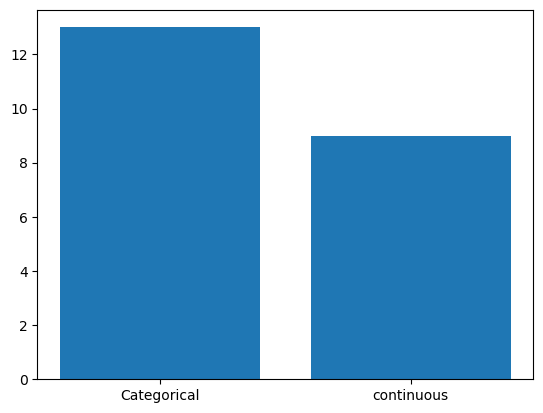

CPU times: total: 78.1 ms
Wall time: 110 ms


In [14]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object', 'bool']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [15]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

In [16]:
cat_features.remove('NObeyesdad')
cat_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'Adult',
 'Adult BMI Predictions',
 'WHO BMI Predictions',
 'CDC BMI Predictions']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

CatBoost
0:	learn: 1.8847583	total: 74.1ms	remaining: 3m 42s
1:	learn: 1.8233766	total: 158ms	remaining: 3m 56s
2:	learn: 1.7687061	total: 240ms	remaining: 4m
3:	learn: 1.7224157	total: 334ms	remaining: 4m 10s
4:	learn: 1.6764166	total: 418ms	remaining: 4m 10s
5:	learn: 1.6375663	total: 502ms	remaining: 4m 10s
6:	learn: 1.5991042	total: 596ms	remaining: 4m 14s
7:	learn: 1.5588598	total: 692ms	remaining: 4m 18s
8:	learn: 1.5195457	total: 780ms	remaining: 4m 19s
9:	learn: 1.4835879	total: 868ms	remaining: 4m 19s
10:	learn: 1.4488883	total: 952ms	remaining: 4m 18s
11:	learn: 1.4184583	total: 1.04s	remaining: 4m 19s
12:	learn: 1.3907885	total: 1.13s	remaining: 4m 19s
13:	learn: 1.3638274	total: 1.22s	remaining: 4m 19s
14:	learn: 1.3361281	total: 1.3s	remaining: 4m 19s
15:	learn: 1.3109218	total: 1.38s	remaining: 4m 18s
16:	learn: 1.2876116	total: 1.47s	remaining: 4m 17s
17:	learn: 1.2630534	total: 1.56s	remaining: 4m 18s
18:	learn: 1.2399119	total: 1.65s	remaining: 4m 19s
19:	learn: 1.2179

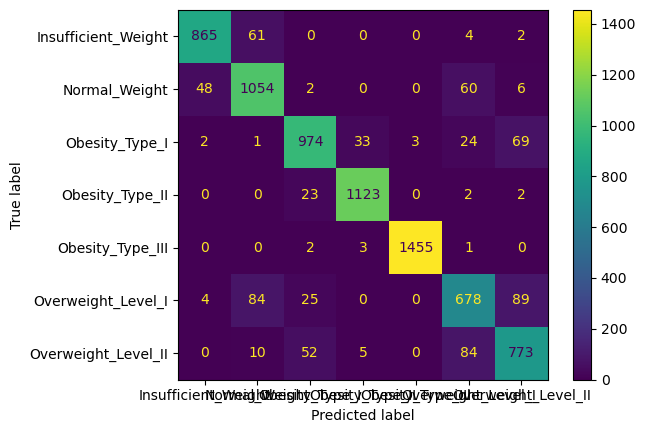

TRAIN - Accuracy: 0.9325068870523416, AUC_ROC_OVO: 0.9946221785746113, AUC_ROC_OVR: 0.9951569749381204
TEST - Accuracy: 0.908041453495999, AUC_ROC_OVO: 0.9889820390037, AUC_ROC_OVR: 0.9900638176169396
[0.9325068870523416, 0.9946221785746113, 0.9951569749381204]
[0.908041453495999, 0.9889820390037, 0.9900638176169396]


In [32]:
# Model 1 - Decision Tree
model = cat.CatBoostClassifier(
    random_seed = 42,
    learning_rate = 0.0175,
    iterations = 3000,
    random_strength = 2
)
train_results, test_results = train_and_evaluate_classifier(f"CatBoost", model, X_train, y_train, X_test, y_test, confusion=True, supress_outputs=False, cat_features=cat_features)
print(train_results)
print(test_results)

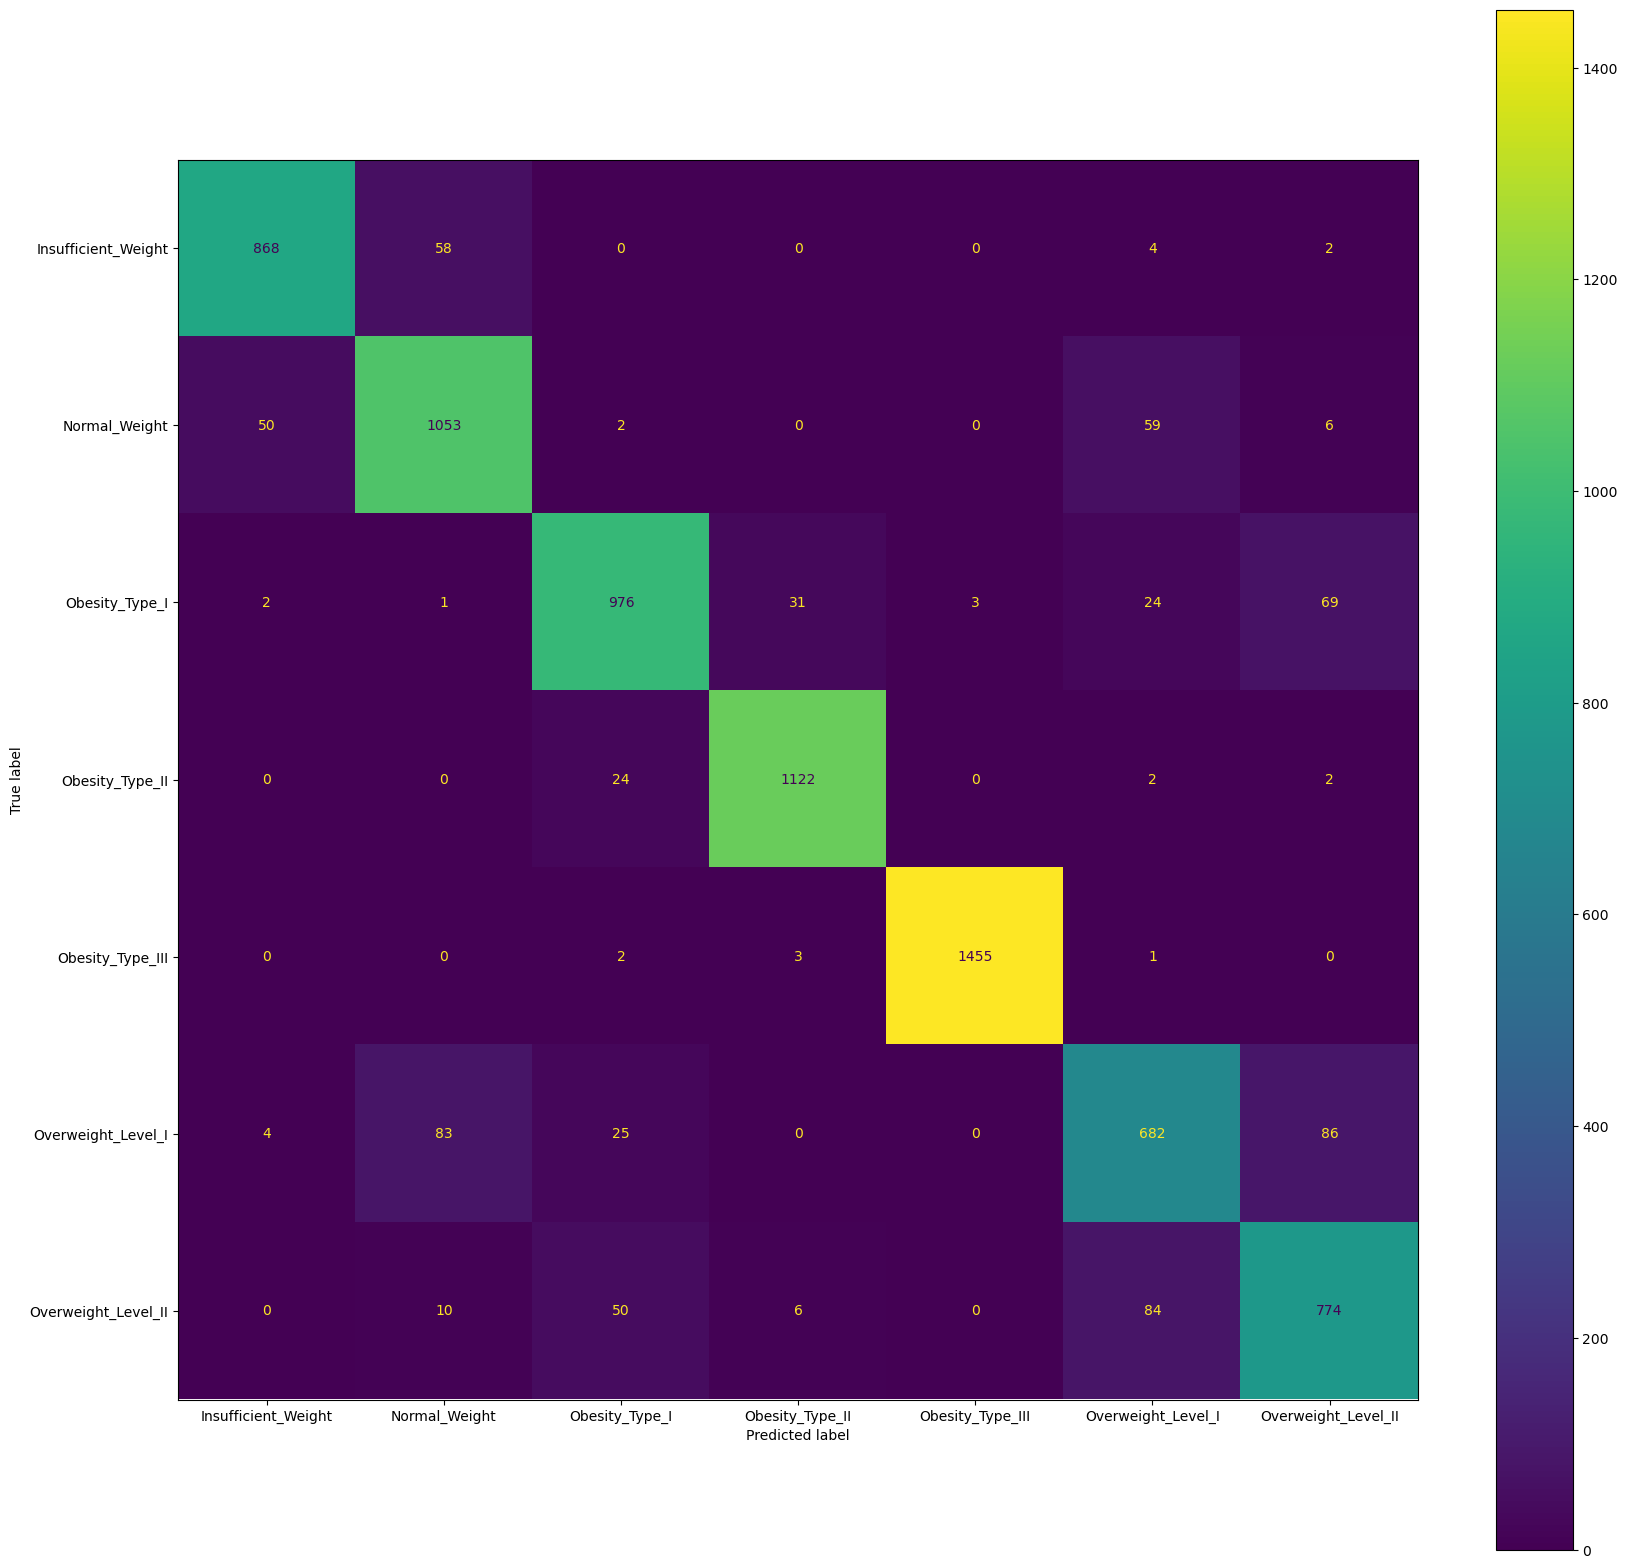

In [29]:
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax = ax)
plt.show()

In [34]:
df3 = pd.read_csv("dataset/test.csv")
df3['BMI'] = df3['Weight'] / (df3['Height'] ** 2)
# df['BMI'].hist()
# df['BMI'].describe()

In [35]:
df3['Adult'] = np.select([df3['Age'] >= 20, df3['Age'] < 20], ["True", "False"]) 

# from https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create a list of our conditions
conditions = [
    (df3['Adult'] == "False"),
    (df3['Adult'] == "True") & (df3['BMI'] < 18.5),
    (df3['Adult'] == "True") & (df3['BMI'] >= 18.5) & (df3['BMI'] < 25),
    (df3['Adult'] == "True") & (df3['BMI'] >= 25) & (df3['BMI'] < 30),
    (df3['Adult'] == "True") & (df3['BMI'] >= 30) & (df3['BMI'] < 35),
    (df3['Adult'] == "True") & (df3['BMI'] >= 35) & (df3['BMI'] < 40),
    (df3['Adult'] == "True") & (df3['BMI'] >= 40)
    ]

# create a list of the values we want to assign for each condition
values = ['N/A', 'underweight', 'healthy', 'overweight', 'obesity class 1', 'obesity class 2', 'obesity class 3']

# create a new column and use np.select to assign values to it using our lists as arguments
df3['Adult BMI Predictions'] = np.select(conditions, values)

In [36]:
WHOBMI_pred = []
CDCBMI_pred = []
df_temp = df3[df3['Adult'] == "False"]
df_needed = df_temp[['Gender', 'Age', 'BMI']]
for index, row in df_needed.iterrows():
    if row['Gender'] == "Male":
        WHO_entry = WHObmi_boys.loc[(WHObmi_boys.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_boys.loc[(CDCbmi_boys.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obesity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obesity class 2')
            else:
                pred.append('obesity class 3')

    elif row['Gender'] == "Female":
        WHO_entry = WHObmi_girls.loc[(WHObmi_girls.Age - row['Age']).abs().idxmin()]
        CDC_entry = CDCbmi_girls.loc[(CDCbmi_girls.Age - row['Age']).abs().idxmin()]

        for (pred, entry) in [(WHOBMI_pred, WHO_entry), (CDCBMI_pred, CDC_entry)]:
            if row['BMI'] < entry['P5']:
                pred.append('underweight')
            elif row['BMI'] >= entry['P5'] and row['BMI'] < entry['P85']:
                pred.append('healthy')
            elif row['BMI'] >= entry['P85'] and row['BMI'] < entry['P95']:
                pred.append('overweight')
            elif row['BMI'] >= entry['P95'] and row['BMI'] < (1.25 * entry['P95']):
                pred.append('obesity class 1')
            elif row['BMI'] >= (1.25 * entry['P95']) and row['BMI'] < (1.4 * entry['P95']):
                pred.append('obesity class 2')
            else:
                pred.append('obesity class 3')
        
# df_temp['WHO BMI Predictions'] = WHOBMI_pred
# df_temp['CDC BMI Predicitons'] = CDCBMI_pred
# df_temp

In [37]:
df3['WHO BMI Predictions'] = 'N/A'
df3['CDC BMI Predictions'] = 'N/A'

df3.loc[df3['Adult'] == 'False', 'WHO BMI Predictions'] = WHOBMI_pred
df3.loc[df3['Adult'] == 'False', 'CDC BMI Predictions'] = CDCBMI_pred
# df

In [38]:
y_preds4 = model.predict(df3.drop(columns='id'))
df = pd.DataFrame(df3['id'])
df.insert(1,"NObeyesdad",y_preds4)
df.to_csv('cat_test_submission4.csv', index=False)